### Prophylactic Efficacy Predictor Vectorized (PEPV)

This package is used to compute the prophylactic efficacy in vectorized way 
such that the computation can be performed for multiple individuals and dosing schemes 
simultaneously. Currently, it is applicable on DTG, TDF, FTC and Truvada (combination of DTG and FTC). To use this package following python packages are neede: torch, pandas, numpy.

Interface of this program is the Class EfficacyPredictor. All functions can be called by an object of this class. To run the computation for a certain regimen, we need to generate an object of Class Regimen by giving the related information about the regimen. Then this Regimen object will be added to the EfficacyPredictor object for the computation of extinction probability / efficacy. 

The following code shows an examplary application of this package:

In [2]:
from PEPV import *       # import this package
import torch             # import the necessary python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Example 1: compute the extinction probability/efficacy for one single drug
All methods are called using the interface class EfficacyPredictor, i.e. first an object of EfficacyPredictor should be generated. 
For each different regimen, an object of class Regimen should be generated, initial arguments for Regimen are: 
1. drug: abbr. of the drug, ('DTG', 'TDF' or 'FTC') 
2. period: period of each dose in hour (e.g. 24 means that pill is taken every 24 hours)
3. time_span: tuple: beginning and end time of this regimen in hour. 0 denotes always the beginning of the first dose, i.e. negative value denotes the time before the first dose is taken. The values of both side should be integer multiple of the period, e.g. if period=24, the time_span should be (i*24, j*24) for i, j are integers. 
4. dose: dosing of the drug in mg, for example 'TDF' dose=300
5. n_doses: doses that should be taken, for example: in a once-daily regimen n_doses=30 (but in computation the actual number of doses may be smaller than 30 because of the adherence)
6. adh_level: adherence level, all n_doses will be taken if adh_level=1; if adh_level<1, random pattern will be generated based on n_doses and adh_level
7. adh_pattern: default parameter, is None by default, can be given if we need a certain pattern of adherence, this pattern should be a 2-D np array or list with 0 and positive integers (usually 0 and 1, denoting how many pills are taken on the corresponding day, can also be greater than 1). It's 2D because the program also supports computing more than one pattern in a run. Example: if the drug is taken every second day: 'adh_pattern= [[1, 0, 1, 0, 1, 0]]'; for two drug taking patterns, once daily and once every second day, the pattern can be: 'adh_pattern=[[1, 1, 1, 1], [1, 0, 1, 0]]'. The first digit in the pattern represents the dosing on the first day, i.e. at time=0 of the time_span. **Important**: if adh_pattern is given, n_doses and adh_level will not be used to generate the adherence pattern, but we still need to input some numbers for the positional arguments. The length of the adh_pattern can be different from time_span, but time_span will be used as standard for the computation: if time_span[0]<0, additional 0 will be added to the beginning of adh_pattern; if time_span[1] > the length of pattern, 0 will also be added to the end of pattern.    

After adding the Regimen object to the EfficacyPredictor object, we can compute the extinction probability or efficacy by calling the corresponding functions. 

In [2]:
# generate a new object of Regimen by giving arguments 
r = Regimen('DTG', 24, (-48, 240), 50, 3, 1)
# generate a new object of EfficacyPredictor
e = EfficacyPredictor()
# add the generated Regimen object to the EfficacyPredictor
e.add_regimen(r)
# compute the extinction probability for the regimen 'r'. 
e.compute_extinction_probability()

A new regimen added. please run the computation again. 


In [3]:
# After computing the extinction probability, we can get the extinction probability 
# of each single viral compartment V, T1 and T2:
pe = e.get_extinction_probability()
pe.shape

torch.Size([14401, 1, 1, 3, 1])

Above is the result of extinction probability. The output is a high-dimensional tensor, with each dimension represents:
1. the steps the program propagates during computation, its value depends on the time_span we give in the Regimen object and the time_step parameter set for ODE solver, i.e. here we run the computation for 240+48 = 288hr, in each hour 50 steps were taken, 288 * 50 =  14400 steps. 
2. the number of individuals, here is 1 meaning that we only compute the extinction probability profile for a individual with average PK parameters. I will show in next example how to run for multiple individuals with different PK parameters.
3. number of adherence tracjectories computed simultaneously, here is 1.
4. three viral compartment for V, T1 and T2, respectively.
5. useless (must have this dimension by computation, no actual meaning)

Usually only the extinction probability of V is important for us.

torch.Size([14401])


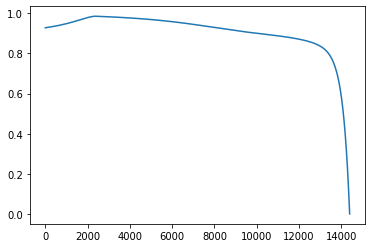

In [4]:
# get the extinction probability of a single virus 
pe_v = pe[:, 0, 0, 0, 0]
print(pe_v.shape)   # one-dimensional array
plt.plot(pe_v)

If we want to compute the effficacy for one single virus, we can also call the following method directly. The shape of efficay array is the same as the first 3 dimensions of the extinction probability array

torch.Size([14401, 1, 1])


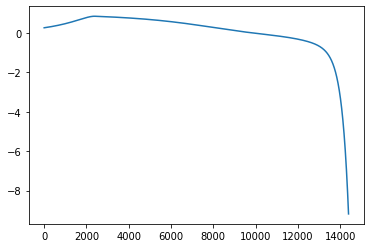

In [5]:
# compute the efficacy of regimem r
e.compute_efficacy()
phi = e.get_efficacy()
print(phi.shape)
plt.plot(phi[:, 0, 0])

You can see here the tail part of the efficacy is not correct since the value is smaller than 0. This is because I initialize the ODE value to solve the extinction probability with [0, 0, 0].  Therefore, if we waant to obtain a correct result for the time-span of interest, we have to extend the input time range. Usually 10 days are more than enough for the extension. 

In [6]:
# extend the input time range with 10 days 
r = Regimen('DTG', 24, (-48, 240 + 10*24), 50, 3, 1)
e = EfficacyPredictor()
e.add_regimen(r)
# compute the efficacy directly
e.compute_efficacy()
phi = e.get_efficacy()

A new regimen added. please run the computation again. 


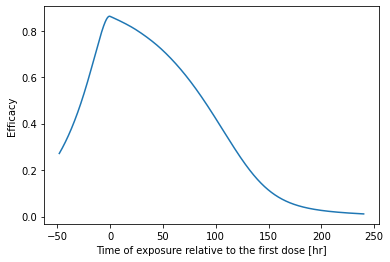

In [7]:
# plot the efficacy profile for the time range of interest
plt.plot([t/50 for t in range(-48*50, 240*50)], phi[:14400, 0, 0])
plt.xlabel('Time of exposure relative to the first dose [hr]')
plt.ylabel('Efficacy')
plt.show()

We can also compute the extinction probability and efficacy profile for multiple individuals simultaneously: add the file containing the PK parameters of corresponding drug before running the computation. The second dimension of the result shows the number of individuals computed.

In [8]:
r = Regimen('DTG', 24, (-48, 24*20), 50, 3, 1)
e = EfficacyPredictor()
e.add_regimen(r)
# add the file containing the PK parameters of DTG for 1000 individuals
e.add_sample_files('Data/DGV50_Params.xlsx')
e.compute_extinction_probability()
pe = e.get_extinction_probability()
print(pe.shape)

A new regimen added. please run the computation again. 
Input file changed, please run the computation again. 
torch.Size([26401, 1000, 1, 3, 1])


#### Example 2: compute the extinction probability/efficacy for drug combinations
We can also run the computation for drug combinations (currently only Truvada available). For this purpose we have to generate two Regimen objects, for FTC and TDF respectively. Time_span and period of these two regimen should be the same. 

**Attention**: the program is stupid designed for this case... if we want to compute the efficacy of Truvada for some adherence level, use the adh_patter argument, not the adh_level, unless the adherence level is 1. Otherwise the result will be wrong... (the reason is that in reality the two drugs will be taken as one pill, but here these two regimen objects are 'independent' from each other. So if we give an adh_level e.g. 0.5, these two regimen objects will randomly generate two different patterns with level 0.5, which doesn't match the reality...)

In [4]:
t0, t1 = -48, 20*24
# dosing pattern starting from the first dose, i.e. t=0 (t<0 is therefore not included in the pattern)
p = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)
e.compute_extinction_probability()
pe = e.get_extinction_probability()
print(pe.shape)

A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
torch.Size([26401, 1, 1, 3, 1])


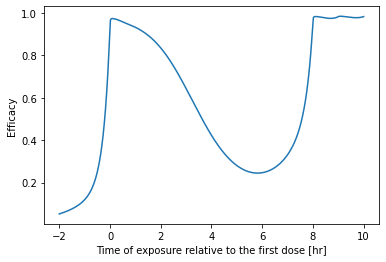

In [5]:
# we can see that the extra 2 days before the first dose were also computed correctly
e.compute_efficacy()
phi = e.get_efficacy()
plt.plot([t/24/50 for t in range(-48*50, 10*24*50)], phi[:14400,0,0])
plt.xlabel('Time of exposure relative to the first dose [hr]')
plt.ylabel('Efficacy')
plt.show()

For Truvada we can also run the computation for multiple individuals, but we have to input the files of PK parameters for TDF and FTC seperately. **Attention**: the files containing the PK parameters of each drug should be added into EfficacyProdictor object in the same order of the corresponding regimen, since the program cannot tell which file represents which drug. 

This computation can take a while for 1000 individuals.

In [11]:
t0, t1 = -48, 20*24
# dosing pattern starting from the first dose, i.e. t=0 (t<0 is therefore not included in the pattern)
p = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_sample_files('Data/ftcmax.csv')
e.add_regimen(r1)
e.add_sample_files('Data/burnssimparam.csv')
e.compute_extinction_probability()
pe = e.get_extinction_probability()
print(pe.shape)

A new regimen added. please run the computation again. 
Input file changed, please run the computation again. 
A new regimen added. please run the computation again. 
Input file changed, please run the computation again. 
torch.Size([26401, 1000, 1, 3, 1])


#### Example 3: some other functions 
This program also has some other small functions:

a) compute or get the drug concentration

b) change the file of MMOA for Truvada

c) change the local-to-PBMC level 

d) change the ODE solver and time step used in solving ODE

In [6]:
# a) we can get concentration of a drug after computing the extinction probability:
t0, t1 = -48, 20*24
p = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)
e.compute_extinction_probability()
# use the getter function to get the concentration of the given drug
c_tdf = e.get_concentration('TDF')
print(c_tdf.shape)
# The first 3 dimentions of the concentration matrix have the same meaning as explained above. 
# The last dimension correspond to the compartments in the PK model. 

A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
torch.Size([26401, 1, 1, 4])


In [7]:
# a) or directly compute the concentration of a drug:
t0, t1 = -48, 20*24
p = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)
e.compute_concentration()
c_tdf = e.get_concentration('TDF')
print(c_tdf.shape)

A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
torch.Size([26401, 1, 1, 4])


In [14]:
# b) change the file of MMOA for Truvada:
t0, t1 = -48, 20*24
p = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)
# change the file which contains the MMOA matrix, default is modMMOA_FTC_TDF_zero_extended.csv
e.set_pd_file('Data/comb_output_VagChen.csv')
# then run the computation normally
e.compute_extinction_probability()

A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
PD file changed


In [15]:
# c) change the local-to-PBMC level
t0, t1 = -48, 20*24
p = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
r = Regimen('FTC', 24, (t0, t1), 200, 30, 1, adh_pattern=p)
r1 = Regimen('TDF', 24, (t0, t1), 300, 30, 1, adh_pattern=p)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)
# to change the concentration according to the local-to-PBMC ratio, we have to: 
# 1. compute the concentration
# 2. set local-to-PBMC ratio for the concentration of certain drug  
# 3. compute the extinction probability /efficacy
e.compute_concentration()
e.set_concentration_proportion('FTC', 0.03)
e.compute_extinction_probability()


A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 


In [26]:
# d) change the ODE solver and time step used in solving ODE
# Because this program is written in vectorized way, ODE solver provided by Scipy cannot be used here. 
# So I wrote my own ODE solver function Euler and RK4. 

# Default ODE solver is Euler (RK1), time step is 0.02hr 
# There are two ODE sets that will be solved in the computation: first is the PK ODE set, 
# second is the ODE set for the PGS to solve the extinction probability.
# Usually we don't need to change the ODE solver and time step for the PGS. 

# Currently I only found one case in which we need to change the ODE solver and time steps:
# if we use the file of TDF ('burnssimparam.csv'), which contains the 1000 virtual patients, we need to change the ODE solver and time step
# to solve the PK ODE set, since some individuals there have super large Ka values. 
# If we don't change the ODE solver and time step, the results will be wrong for the individuals whose Ka values
# larger than 100.


t0, t1 = 0, 15*24
r = Regimen('FTC', 24, (t0, t1), 200, 10, 1)
r1 = Regimen('TDF', 24, (t0, t1), 300, 10, 1)
e = EfficacyPredictor()
e.add_regimen(r)
e.add_regimen(r1)
e.add_sample_files('./Data/ftcmax.csv')
e.add_sample_files('./Data/burnssimparam.csv')
e.set_pk_ode_solver('TDF', rk4)      # change ODE solver for TDF to solve the PK ODE
e.set_pk_time_step('TDF', 0.002)     # change time step fot TDF to solve PK ODE. 
e.compute_extinction_probability()

# Computation can be slow for 1000 individuals. 

A new regimen added. please run the computation again. 
A new regimen added. please run the computation again. 
Input file changed, please run the computation again. 
Input file changed, please run the computation again. 
ODE solver for PK changed, please run the computation again. 
Time step for PK changed, please run the computation again.
